<a href="https://colab.research.google.com/github/O-Kpy/Kaggle/blob/main/tabular_playground_series_sep_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
import scipy
from scipy.stats import skew, boxcox_normmax

In [2]:
train = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-sep/tabular-playground-series-sep-2021_train.csv')
test = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-sep/tabular-playground-series-sep-2021_test.csv')

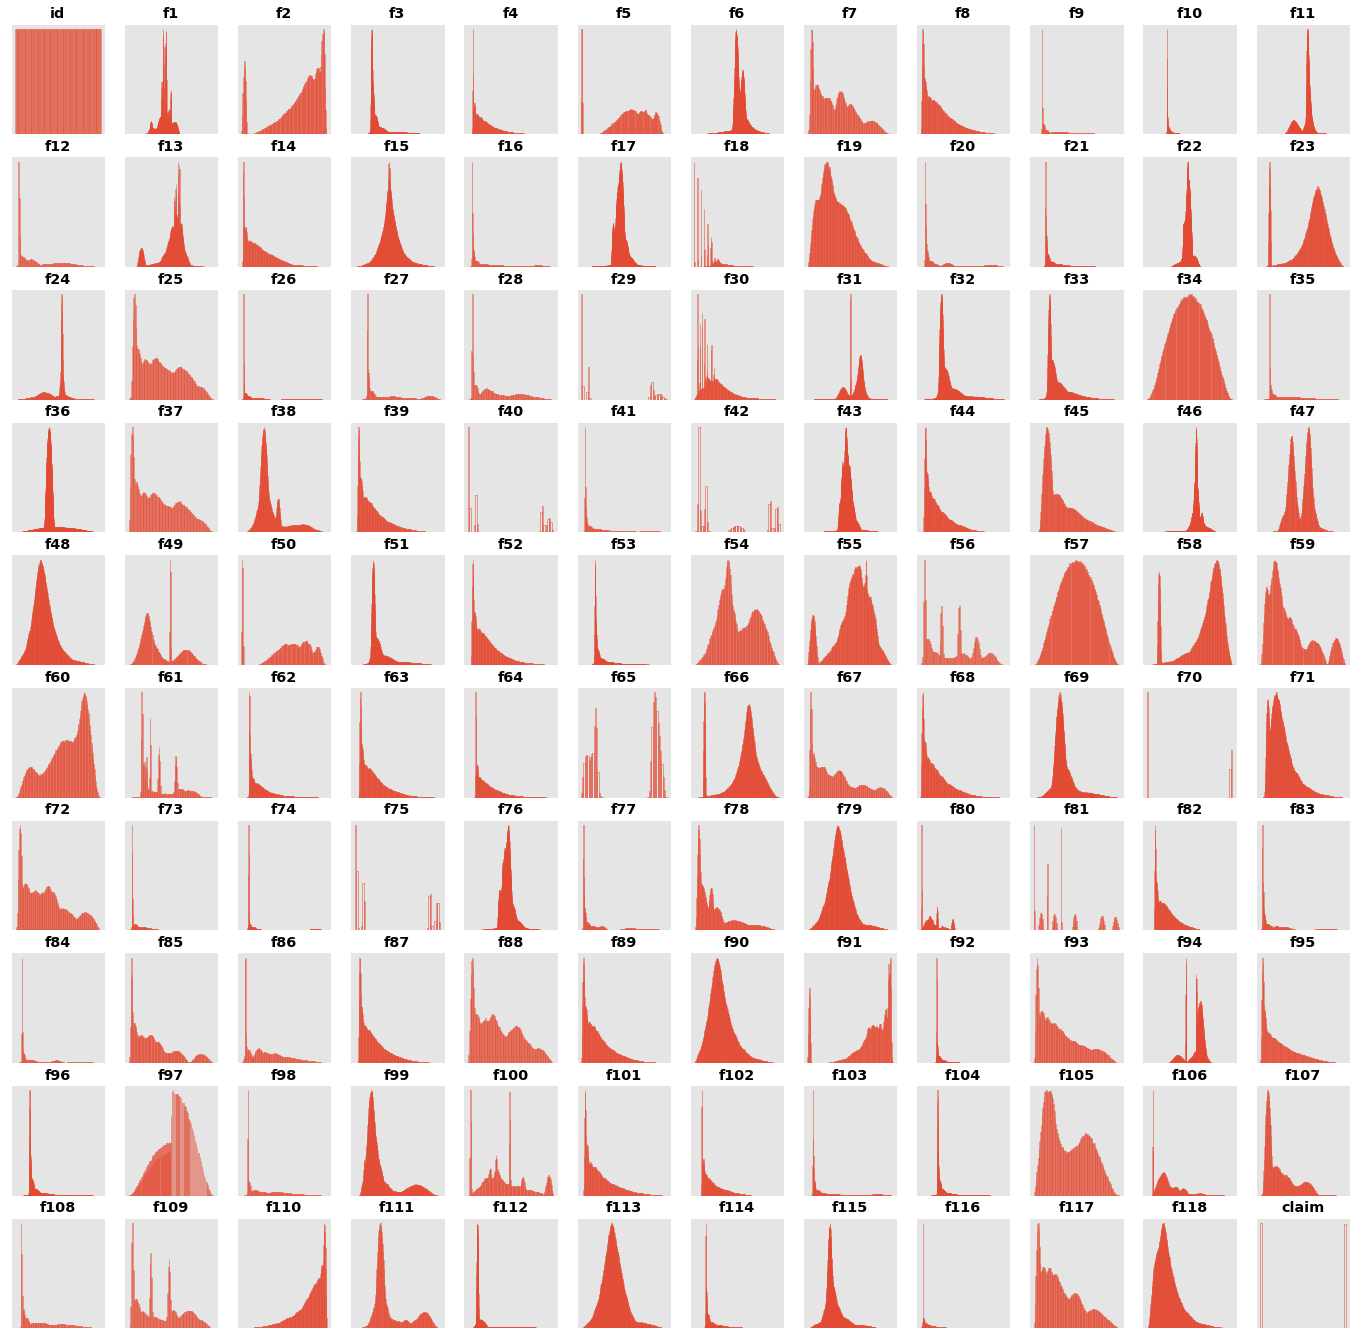

In [ ]:
plt.figure(figsize=(24,24))
for i, j in enumerate(train.columns):
  plt.subplot(10, 12, i+1)
  sns.histplot(x=train[j], fill=False)
  plt.xlabel('')
  plt.ylabel('')
  plt.xticks([])
  plt.yticks([])
  plt.title(f'{j}', fontweight='bold')

In [3]:
train['na'] = train.isnull().sum(axis=1)
test['na'] = test.isnull().sum(axis=1)

In [ ]:
!pip install catboost
!pip install optuna

In [4]:
from sklearn.impute import SimpleImputer
import catboost
import optuna
import lightgbm
import xgboost
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [5]:
# data splits

x_train = train.drop(columns=['claim', 'id'])
y_train = train['claim']
x_test = test.drop(columns=['id'])

train_columns = x_train.columns
test_columns = x_test.columns

In [6]:
# 누락값(impute)
x_train = pd.DataFrame(SimpleImputer(strategy='mean').fit_transform(x_train), columns=train_columns)
x_test = pd.DataFrame(SimpleImputer(strategy='mean').fit_transform(x_test), columns=test_columns)

In [7]:
# scaling
sc = StandardScaler().fit(x_train)
x_train = pd.DataFrame(sc.transform(x_train), columns=train_columns)
x_test = pd.DataFrame(sc.transform(x_test), columns=test_columns)

# mc = MinMaxScaler().fit(x_train)
# x_train = pd.DataFrame(mc.transform(x_train), columns=train_columns)
# x_test = pd.DataFrame(mc.transform(x_test), columns=test_columns)

# Catboost [LB : 0.81691]

In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
sf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
preds = 0

for i, (train_index, valid_index) in enumerate(sf.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_cat = catboost.CatBoostClassifier(eval_metric='AUC', task_type='GPU', iterations=5000)
  model_cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), verbose=100, early_stopping_rounds=70)
  preds += model_cat.predict_proba(x_test)[:,1] / sf.n_splits

In [8]:
def objective(trial,data=x_train,target=y_train):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,random_state=42)
    params = {'iterations':trial.suggest_int("iterations", 2000, 40000, step=1000),
              'task_type':"GPU",
              'eval_metric':'AUC',
              'objective':'CrossEntropy',
              'leaf_estimation_method':'Newton',
              'bootstrap_type': 'Bernoulli',
              'learning_rate' : trial.suggest_uniform('learning_rate',0.01,0.5),
              'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
              'subsample': trial.suggest_uniform('subsample',0,1),
              'random_strength': trial.suggest_uniform('random_strength',10,50),
              'depth': trial.suggest_int('depth',1,13),
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,50),
              'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
              'grow_policy' : 'Depthwise',
               }
    model = catboost.CatBoostClassifier(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
        
    y_preds = model.predict_proba(X_test)[:,1]


    AUC = roc_auc_score(y_test, y_preds)
    
    return AUC

In [ ]:
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

params_cat = {
    'iterations'  :study.best_params['iterations'],
    'task_type':"GPU",
    'eval_metric':'AUC',
    'objective':'CrossEntropy',
    'leaf_estimation_method':'Newton',
    'bootstrap_type': 'Bernoulli',
    'learning_rate' : study.best_params['learning_rate'],
    'reg_lambda': study.best_params['reg_lambda'],
    'subsample': study.best_params['subsample'],
    'random_strength': study.best_params['random_strength'],
    'depth':study.best_params['depth'],
    'min_data_in_leaf': study.best_params['min_data_in_leaf'],
    'leaf_estimation_iterations': study.best_params['leaf_estimation_iterations'],
    'grow_policy' : 'Depthwise'
}

In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
sf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
preds = 0
params_cat = {
    'iterations'  :study.best_params['iterations'],
    'task_type':"GPU",
    'eval_metric':'AUC',
    'objective':'CrossEntropy',
    'leaf_estimation_method':'Newton',
    'bootstrap_type': 'Bernoulli',
    'learning_rate' : study.best_params['learning_rate'],
    'reg_lambda': study.best_params['reg_lambda'],
    'subsample': study.best_params['subsample'],
    'random_strength': study.best_params['random_strength'],
    'depth':study.best_params['depth'],
    'min_data_in_leaf': study.best_params['min_data_in_leaf'],
    'leaf_estimation_iterations': study.best_params['leaf_estimation_iterations'],
    'grow_policy' : 'Depthwise'
}

for i, (train_index, valid_index) in enumerate(sf.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_cat = catboost.CatBoostClassifier(**params_cat)
  model_cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), verbose=100, early_stopping_rounds=70)
  preds += model_cat.predict_proba(x_test)[:,1] / sf.n_splits

# LGBM [LB : 0.81742]

In [ ]:
!git clone --recursive https://github.com/Microsoft/LightGBM
%cd /content/LightGBM

!mkdir build
!cmake -DUSE_GPU=1
!make -j$(nproc)
!sudo apt-get -y install python-pip
!sudo -H pip install setuptools pandas numpy scipy scikit-learn -U
%cd /content/LightGBM/python-package/
!sudo python setup.py install --precompile

In [10]:
def objective(trial,data=x_train,target=y_train):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,random_state=42)
    params = {
            "n_estimators": trial.suggest_int('n_estimators', 2000, 40000, step=500),
            "objective": "binary",
            "metric": "AUC", 
            "verbosity": -1,
            "learning_rate": trial.suggest_uniform('learning_rate', 0.001, 1.0),
            "reg_alpha": trial.suggest_uniform('reg_alpha', 1e-3, 10.0),
            "reg_lambda": trial.suggest_uniform('reg_lambda', 1e-3, 10.0),
            "colsample_bytree": trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
            "subsample": trial.suggest_uniform('subsample', 0.4, 1.0),
            "subsample_freq": trial.suggest_categorical("subsample_freq", [1,2]),
            "max_depth": trial.suggest_int('max_depth', 1, 14),
            "num_leaves" : trial.suggest_int('num_leaves', 2, 256),
            "min_child_weight" : trial.suggest_categorical("min_child_weight", [128,256]),
            "min_child_samples": trial.suggest_int('min_child_samples', 1, 200),
            "device": "gpu"
        }
    model = lightgbm.LGBMClassifier(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
        
    y_preds = model.predict_proba(X_test)[:,1]


    AUC = roc_auc_score(y_test, y_preds)
    
    return AUC

In [ ]:
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

params_lgbm = {
    "n_estimators": study.best_params['n_estimators'],
    "objective": "binary",
    "metric": "AUC", 
    "verbosity": -1,
    "learning_rate": study.best_params['learning_rate'],
    "reg_alpha": study.best_params['reg_alpha'],
    "reg_lambda": study.best_params['reg_lambda'],
    "colsample_bytree": study.best_params['colsample_bytree'],
    "subsample": study.best_params['subsample'],
    "subsample_freq": study.best_params['subsample_freq'],
    "max_depth": study.best_params['max_depth'],
    "num_leaves" : study.best_params['num_leaves'],
    "min_child_weight" : study.best_params['min_child_weight'],
    "min_child_samples": study.best_params['min_child_samples'],
    "device": "gpu" 
}

# XGBoost

In [ ]:
def objective(trial, data=x_train, target=y_train):

  X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
  params = {
      'n_estimators' : trial.suggest_int('n_estimators', 2000, 40000, step=500),
      'objective' : trial.suggest_categorical('objective', ['binary:logistic', 'binary:logitraw', 'binary:hinge']),
      'eval_metric' : 'auc',
      'learning_rate' : trial.suggest_uniform('learning_rate', 0.001, 0.8),
      'reg_alpha' : trial.suggest_uniform('reg_alpha', 1e-3, 10.0),
      'reg_lambda' : trial.suggest_uniform('reg_lambda', 1e-3, 10.0),
      'colsample_bytree' : trial.suggest_uniform('colsample_bytree', 0.1, 1.0),
      'subsample' : trial.suggest_uniform('subsample', 0.4, 1.0),
      'subsample_freq' : trial.suggest_categrical('subsample_freq', [1,2]),
      'max_depth' : trial.suggest_int('max_depth', 1, 14),
      'num_leaves' : trial.suggest_int('num_leaves', 2, 256),
      'min_child_weight' : trial.suggest_categorical('min_child_weight', [128, 256]),
      'min_child_sample' : trial.suggest_int('min_child_sample', 1, 200),
      'tree_method' : 'gpu_hist',
      # 'grow_policy' : 'lossguide'
   }
  model = xgboost.XGBClassifier(**params)
  model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)

  y_preds = model.predict_proba(X_test)[:,1]

  AUC = roc_auc_score(y_test, y_preds)

  return AUC

In [12]:
def objective(trial,data=x_train,target=y_train):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,random_state=42)
    params = {
            "n_estimators": trial.suggest_int('n_estimators', 2000, 40000, step=500),
            "objective" : "binary:logistic",
            "eval_metric": "auc",
            "learning_rate": trial.suggest_uniform('learning_rate', 0.001, 1.0),
            "reg_alpha": trial.suggest_uniform('reg_alpha', 1e-3, 10.0),
            "reg_lambda": trial.suggest_uniform('reg_lambda', 1e-3, 10.0),
            "colsample_bytree": trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
            "subsample": trial.suggest_uniform('subsample', 0.4, 1.0),
            "subsample_freq": trial.suggest_categorical("subsample_freq", [1,2]),
            "max_depth": trial.suggest_int('max_depth', 1, 14),
            "num_leaves" : trial.suggest_int('num_leaves', 2, 256),
            "min_child_weight" : trial.suggest_categorical("min_child_weight", [128,256]),
            "min_child_samples": trial.suggest_int('min_child_samples', 1, 200),
            'tree_method' : 'gpu_hist',
            # 'grow_policy' : 'lossguide' 
        }
    model = xgboost.XGBClassifier(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
        
    y_preds = model.predict_proba(X_test)[:,1]


    AUC = roc_auc_score(y_test, y_preds)
    
    return AUC

In [ ]:
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

params_xgb = {
    "n_estimators": study.best_params['n_estimators'],
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": study.best_params['learning_rate'],
    "reg_alpha": study.best_params['reg_alpha'],
    "reg_lambda": study.best_params['reg_lambda'],
    "colsample_bytree": study.best_params['colsample_bytree'],
    "subsample": study.best_params['subsample'],
    "subsample_freq": study.best_params['subsample_freq'],
    "max_depth": study.best_params['max_depth'],
    "num_leaves" : study.best_params['num_leaves'],
    "min_child_weight" : study.best_params['min_child_weight'],
    "min_child_samples": study.best_params['min_child_samples'],
    'tree_method' : 'gpu_hist',
     # 'grow_policy' : 'lossguide' 
}

In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
sf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
preds = 0
params_xgb = {
    "n_estimators": study.best_params['n_estimators'],
    "objective": study.best_params['objective'],
    "eval_metric": "auc",
    "learning_rate": study.best_params['learning_rate'],
    "reg_alpha": study.best_params['reg_alpha'],
    "reg_lambda": study.best_params['reg_lambda'],
    "colsample_bytree": study.best_params['colsample_bytree'],
    "subsample": study.best_params['subsample'],
    "subsample_freq": study.best_params['subsample_freq'],
    "max_depth": study.best_params['max_depth'],
    "num_leaves" : study.best_params['num_leaves'],
    "min_child_weight" : study.best_params['min_child_weight'],
    "min_child_samples": study.best_params['min_child_samples'],
    'tree_method' : 'gpu_hist',
     # 'grow_policy' : 'lossguide' 
}

for i, (train_index, valid_index) in enumerate(sf.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_xgb = xgboost.XGBClassifier(**params_xgb)
  model_xgb.fit(X_train, Y_train, eval_set=((X_train, Y_train), (X_valid, Y_valid)), verbose=100, early_stopping_rounds=70)

  preds += model_xgb.predict_proba(x_test)[:,1] / sf.n_splits

In [22]:
# params
params_cat = {'iterations': 10000, 'learning_rate': 0.016407470572066457, 'reg_lambda': 60.448210697127735, 'subsample': 0.3672760586674048, 'random_strength': 31.793243736616244, 'depth': 6, 'min_data_in_leaf': 30, 'leaf_estimation_iterations': 13, 'task_type':"GPU", 'eval_metric':'AUC', 'objective':'CrossEntropy', 'leaf_estimation_method':'Newton', 'bootstrap_type': 'Bernoulli', 'grow_policy' : 'Depthwise'}
params_lgbm = {'n_estimators': 8500, 'learning_rate': 0.005835118607037089, 'reg_alpha': 2.40658559202166, 'reg_lambda': 8.526178376593318, 'colsample_bytree': 0.45053692006675006, 'subsample': 0.6633114406695187, 'subsample_freq': 1, 'max_depth': 14, 'num_leaves': 179, 'min_child_weight': 128, 'min_child_samples': 179, "device": "gpu", "objective": "binary", "metric": "AUC", "verbosity": -1,}
params_xgb = {'n_estimators': 10500, 'learning_rate': 0.0066188674724684815, 'reg_alpha': 1.8809109051997521, 'reg_lambda': 4.142760640388884, 'colsample_bytree': 0.4274574517035539, 'subsample': 0.7507892843997079, 'subsample_freq': 1, 'max_depth': 5, 'num_leaves': 82, 'min_child_weight': 128, 'min_child_samples': 7, "eval_metric": "auc", 'tree_method' : 'gpu_hist', "objective": "binary:logistic"}

In [23]:
cat = catboost.CatBoostClassifier(**params_cat)
xgb = xgboost.XGBClassifier(**params_xgb)
lgb = lightgbm.LGBMClassifier(**params_lgbm)

In [20]:
def cross_validate_model(class_name, x_train, y_train, n_splits=5):
  sf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

  oof_preds=0

  test_preds = 0
  y_valid_meta_lgb = 0

  for i,(train_index, valid_index) in enumerate(sf.split(x_train, y_train)):
    X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
    Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

    print(f"{'-'*10} Fold {i+1} Started {'-'*10}")
    clf = class_name
    clf = clf.fit(X_train, Y_train, eval_set = [(X_valid, Y_valid)], early_stopping_rounds=70, verbose=200)
    preds = clf.predict_proba(X_valid)[:,1]

    y_valid_meta_lgb = clf.predict_proba(X_valid)[:,1]

    test_preds += clf.predict_proba(x_test)[:,1] / sf.n_splits

    ra_score = roc_auc_score(Y_valid, y_valid_meta_lgb)

  print(f"ROC AUC of current fold is {ra_score}")

  return y_valid_meta_lgb, test_preds

In [24]:
cat_oof, cat_preds = cross_validate_model(cat, x_train, y_train)
lgb_oof, lgb_preds = cross_validate_model(lgb, x_train, y_train)

---------- Fold 1 Started ----------


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 0.8017753	test: 0.8000649	best: 0.8000649 (0)	total: 23.1ms	remaining: 3m 51s
200:	learn: 0.8182372	test: 0.8088052	best: 0.8088052 (200)	total: 3.77s	remaining: 3m 3s
400:	learn: 0.8229652	test: 0.8108642	best: 0.8108642 (400)	total: 7.48s	remaining: 2m 59s
600:	learn: 0.8263137	test: 0.8119766	best: 0.8119766 (600)	total: 11.2s	remaining: 2m 55s
800:	learn: 0.8288994	test: 0.8127727	best: 0.8127727 (800)	total: 14.9s	remaining: 2m 51s
1000:	learn: 0.8312554	test: 0.8133629	best: 0.8133629 (1000)	total: 18.6s	remaining: 2m 47s
1200:	learn: 0.8333551	test: 0.8137475	best: 0.8137492 (1194)	total: 22.3s	remaining: 2m 43s
1400:	learn: 0.8353451	test: 0.8139987	best: 0.8139987 (1400)	total: 26s	remaining: 2m 39s
1600:	learn: 0.8372777	test: 0.8142584	best: 0.8142596 (1599)	total: 29.7s	remaining: 2m 35s
1800:	learn: 0.8391513	test: 0.8144893	best: 0.8144893 (1800)	total: 33.3s	remaining: 2m 31s
2000:	learn: 0.8409772	test: 0.8145956	best: 0.8145980 (1988)	total: 37s	remaining: 2m

/usr/local/lib/python3.7/dist-packages/lightgbm/sklearn.py:723: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/sklearn.py:733: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[200]	valid_0's auc: 0.807006
[400]	valid_0's auc: 0.809612
[600]	valid_0's auc: 0.81113
[800]	valid_0's auc: 0.812096
[1000]	valid_0's auc: 0.812776
[1200]	valid_0's auc: 0.813247
[1400]	valid_0's auc: 0.813619
[1600]	valid_0's auc: 0.813977
[1800]	valid_0's auc: 0.814244
[2000]	valid_0's auc: 0.814436
[2200]	valid_0's auc: 0.814598
[2400]	valid_0's auc: 0.814738
[2600]	valid_0's auc: 0.814917
[2800]	valid_0's auc: 0.815065
[3000]	valid_0's auc: 0.815149
[3200]	valid_0's auc: 0.815236
[3400]	valid_0's auc: 0.815331
[3600]	valid_0's auc: 0.815421
[3800]	valid_0's auc: 0.815495
[4000]	valid_0's auc: 0.815569
[4200]	valid_0's auc: 0.815611
[4400]	valid_0's auc: 0.815654
[4600]	valid_0's auc: 0.815697
---------- Fold 2 Started ----------


/usr/local/lib/python3.7/dist-packages/lightgbm/sklearn.py:723: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/sklearn.py:733: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[200]	valid_0's auc: 0.807585
[400]	valid_0's auc: 0.810463
[600]	valid_0's auc: 0.812128
[800]	valid_0's auc: 0.813089
[1000]	valid_0's auc: 0.813746
[1200]	valid_0's auc: 0.814225
[1400]	valid_0's auc: 0.814613
[1600]	valid_0's auc: 0.814994
[1800]	valid_0's auc: 0.815225
[2000]	valid_0's auc: 0.815455
[2200]	valid_0's auc: 0.815664
[2400]	valid_0's auc: 0.81583
[2600]	valid_0's auc: 0.815976
[2800]	valid_0's auc: 0.816106


KeyboardInterrupt: ignored

In [ ]:
def xgb_cross_validate_model(class_name, x_train, y_train, n_splits=5):
  sf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

  oof_preds, oof_y = [], []

  test_preds = np.zeros((x_test.shape[0]))
  y_valid_meta_lgb = np.zeros((x_train.shape[0]))

  for i,(train_index, valid_index) in enumerate(sf.split(x_train, y_train)):
    X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
    Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

    print(f"{'-'*10} Fold {i+1} Started {'-'*10}")
    clf = class_name
    clf = clf.fit(X_train, Y_train, eval_set = [(X_train, Y_train), (X_valid, Y_valid)], early_stopping_rounds=70, verbose=200)
    preds = clf.predict_proba(X_valid)[:,1]

    y_valid_meta_lgb += clf.predict_proba(X_valid)[:,1] / sf.n_splits

    test_preds += clf.predict_proba(x_test)[:,1] / sf.n_splits

    ra_score = roc_auc_score(Y_valid, preds)

  print(f"ROC AUC of current fold is {ra_score}")

  return y_valid_meta_lgb, test_preds

In [ ]:
xgb_oof, xgb_preds = xgb_cross_validate_model(xgb, x_train, y_train)

In [ ]:
oof = np.concatenate((cat_oof, xgb_oof, lgb_oof), axis=1)
preds = np.concatenate((cat_preds, xgb_preds, lgb_preds), axis=1)

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for i, (train_index, valid_index) in enumerate(kf.split(oof, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model = LogisticRegression(
            max_iter=3000,
            random_state=42
        )
  model.fit(X_train, Y_train, eval_set=((X_train, Y_train), (X_valid, Y_valid)), verbose=100, early_stopping_rounds=70)

  stacking_preds += model.predict_proba(preds)[:,1] / kf.n_splits

# To Do

- 하이퍼파라미터 돌린거 코드로 나타내기

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-sep/tabular-playground-series-sep-2021_sample_solution.csv')
submit['claim'] = preds
submit.to_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-sep/submit6.csv', index=False)
submit

,id,claim
0,957919,0.584806
1,957920,0.121539
2,957921,0.629069
3,957922,0.127778
4,957923,0.152864
...,...,...
493469,1451388,0.823289
493470,1451389,0.111646
493471,1451390,0.756025
493472,1451391,0.136460
